In [1]:
import numpy as np
from sklearn.metrics import mean_squared_error
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config inlineBackend.figure_formats = ['svg']
# Import from Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statistics as sts
import matplotlib.pyplot as plt
from matplotlib import cm
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import scipy.stats as stat
import pylab
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from scipy.stats import ttest_ind
from sklearn import metrics
from scipy.stats import spearmanr
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.svm import SVC,SVR
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import r2_score,accuracy_score,f1_score
import warnings
from scipy import stats
warnings.filterwarnings('ignore')
# Dataset view settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 90)

functions to help us to draw graphs

In [2]:
def plots_helper(column): # calculating the IQR to detrmine the exact number of outliers in each feature and skewness
    Q3 = np.quantile(column, 0.75)
    Q1 = np.quantile(column, 0.25)
    IQR = Q3 - Q1
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    oc = len(column[column>upper_range]) + len(column[column<lower_range])
    percent = round((oc/len(column))*100,2)
    sk = round(stat.skew(column),2)
    return oc , percent , sk

In [3]:
def box_dist_prob_plots(df): # BoxPlot , Distribution, Histogram and ProbabilityPlot
    number_features = len(df.columns)
    
    plt.figure(figsize = (25,number_features*6))
    for column,i in zip(df,range(1,number_features*3+1,3)):
        
        # coalculating the outliers and its percentage
            
        oc , percent , sk = plots_helper(df[column])

        # plotting the 3 diagrams for each feature
        plt.subplot(number_features, 3, i)
        sns.boxplot(df[column])
        plt.xlabel(column, size=14)
        plt.title(f'Number of outliers {oc} ({percent}%)', fontsize=12, color ='red', fontweight = 'bold')
        
        plt.subplot(number_features, 3, i+1)
        sns.distplot(df[column],kde=False)
        plt.title(f'Skewness = {sk}', fontsize=12, color ='red', fontweight = 'bold')
        plt.xlabel(column, size=14)
        plt.ylabel("Count", size=14)
        plt.axvline(x=df[column].median(),ls='--')
        plt.axvline(x=df[column].mean())
        plt.legend(['mean', 'median'])
        
        plt.subplot(number_features, 3, i+2)
        stat.probplot(df[column],dist='norm',plot=pylab,rvalue=True)
        

In [4]:
def box_for_one_col(column,name):
    oc , percent , sk = plots_helper(column)

    # plotting the 3 diagrams for each feature
    plt.subplot(1, 3, 1)
    sns.boxplot(column)
    plt.xlabel(name, size=14)
    plt.title(f'Number of outliers {oc} ({percent}%)', fontsize=12, color ='red', fontweight = 'bold')
    
    plt.subplot(1, 3, 2)
    sns.distplot(column,kde=False)
    plt.title(f'Skewness = {sk}', fontsize=12, color ='red', fontweight = 'bold')
    plt.xlabel(name, size=14)
    plt.ylabel("Count", size=14)
    plt.axvline(x=column.median(),ls='--')
    plt.axvline(x=column.mean())
    plt.legend(['mean', 'median'])
    
    plt.subplot(1, 3, 3)
    stat.probplot(column,dist='norm',plot=pylab,rvalue=True)

function to remove outliers using IQR

In [5]:
# Define a function to remove outliers based on the IQR
def remove_outliers_iqr(df, col_name):
    Q1 = df[col_name].quantile(0.25)
    Q3 = df[col_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5*IQR
    upper_bound = Q3 + 1.5*IQR
    df_filtered = df[(df[col_name] > lower_bound) & (df[col_name] < upper_bound)]
    return df_filtered

# Remove outliers from the DataFrame

read data

In [6]:
df=pd.read_csv('/kaggle/input/udemy-courses-revenue-generation-and-course-anal/Entry Level Project Sheet - 3.1-data-sheet-udemy-courses-web-development.csv')


see samples

In [7]:
df.sample(5)

,course_id,course_title,url,price,num_subscribers,num_reviews,num_lectures,level,rating,content_duration,published_timestamp,subject,Date,Free/Paid
783,909836,Ultimate JavaScript Strings,https://www.udemy.com/js-strings/,0,3142,117,20,Beginner Level,0.80,0.616667,2016-07-29T12:53:13Z,Web Development,2016-07-29,Free
597,681514,Complete PHP Course with OOP Start to Finish!,https://www.udemy.com/complete-object-oriented-programming-in-php-start-to-finish/,200,4529,54,29,All Levels,0.89,2.000000,2015-11-26T22:25:33Z,Web Development,2015-11-26,Paid
2710,733654,なぞるだけですぐできる! 簡単手描きイラスト講座,https://www.udemy.com/nazoru-illust/,30,123,12,48,All Levels,0.98,3.000000,2016-02-16T17:10:15Z,Graphic Design,2016-02-16,Paid
3136,805706,Bagpipe Instruction For Beginners,https://www.udemy.com/bagpipe-instruction-for-beginners/,30,31,4,5,All Levels,0.11,1.000000,2016-04-24T16:32:40Z,Musical Instruments,2016-04-24,Paid
3081,733922,Aprende el acordeón de oído y con técnica –Nivel Intermedio–,https://www.udemy.com/aprende-el-acordeon-de-oido-y-con-tecnica-nivel-intermedio/,25,38,7,51,Beginner Level,0.11,4.500000,2016-02-03T03:04:26Z,Musical Instruments,2016-02-03,Paid


check different subjects

In [8]:
pd.unique(df["subject"])

array(['Web Development', 'Musical Instruments', 'Business Finance',
       'Graphic Design'], dtype=object)

see information data for example columns and number , nulls and # of rows

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3676 entries, 0 to 3675
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   course_id            3676 non-null   int64  
 1   course_title         3676 non-null   object 
 2   url                  3676 non-null   object 
 3   price                3676 non-null   int64  
 4   num_subscribers      3676 non-null   int64  
 5   num_reviews          3676 non-null   int64  
 6   num_lectures         3676 non-null   int64  
 7   level                3676 non-null   object 
 8   rating               3676 non-null   float64
 9   content_duration     3676 non-null   float64
 10  published_timestamp  3676 non-null   object 
 11  subject              3676 non-null   object 
 12  Date                 3676 non-null   object 
 13  Free/Paid            3676 non-null   object 
dtypes: float64(2), int64(5), object(7)
memory usage: 402.2+ KB


here to notice min for duration and num of lectures =0 that is mistake (we will solvve it later)

In [10]:
df.describe()

,course_id,price,num_subscribers,num_reviews,num_lectures,rating,content_duration
count,3.676000e+03,3676.000000,3676.000000,3676.000000,3676.000000,3676.000000,3676.000000
mean,6.757535e+05,66.115343,3199.260881,156.309848,40.129761,0.610868,4.096137
std,3.431304e+05,61.056073,9486.582966,935.674518,50.398507,0.334287,6.054948
min,8.324000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.074740e+05,20.000000,112.000000,4.000000,15.000000,0.280000,1.000000
50%,6.876920e+05,45.000000,912.500000,18.000000,25.000000,0.760000,2.000000
75%,9.608140e+05,95.000000,2558.000000,67.000000,46.000000,0.930000,4.500000
max,1.282064e+06,200.000000,268923.000000,27445.000000,779.000000,1.000000,78.500000


**Data Cleaning**

check duplicate and remove them if found

In [11]:
df[df.duplicated()]

,course_id,course_title,url,price,num_subscribers,num_reviews,num_lectures,level,rating,content_duration,published_timestamp,subject,Date,Free/Paid


remove columns we do not need them (url, course id)

In [12]:
df.drop('url',axis=1,inplace=True)

In [13]:
df.drop('course_id',axis=1,inplace=True)

check type time


In [14]:
type(df ['published_timestamp'][0])

str

covert it to date time

In [15]:
df ['published_timestamp'] = pd.to_datetime(df ['published_timestamp']).dt.date
df ['Date'] = pd.to_datetime(df ['Date']).dt.date

we notice free/paid  and price  column(-_-)

In [16]:
df.sample(5)

,course_title,price,num_subscribers,num_reviews,num_lectures,level,rating,content_duration,published_timestamp,subject,Date,Free/Paid
459,Basic Bookkeeping Hacks,20,5841,16,28,Beginner Level,0.29,1.5,2016-06-14,Business Finance,2016-06-14,Paid
3449,Nest Egg Investing,45,6,0,12,Intermediate Level,0.69,2.0,2014-06-27,Business Finance,2014-06-27,Paid
2704,CFA Level I Workshop 2: Financial Reporting & Analysis I,20,126,2,5,Intermediate Level,0.80,1.0,2013-08-12,Business Finance,2013-08-12,Paid
1774,7 Secrets To Designing In Black and White,100,1000,1,12,Intermediate Level,0.79,1.5,2017-06-27,Graphic Design,2017-06-27,Paid
3230,Energiespar-Formel // Mehr Geld durch Wasser sparen Zuhause,50,21,2,54,Beginner Level,0.88,1.5,2017-04-14,Business Finance,2017-04-14,Paid


we check here if we find row free and price has value (mistake) or paid and price =0 (also mistake) 

In [17]:
rslt_df = df[(df['price'] != 0) &
          (df['Free/Paid']=="Paid")]
  
#print('\nResult dataframe :\n', rslt_df)

In [18]:
rslt_df = df[(df['price'] == 0) &
          (df['Free/Paid']=="Free")]
  
#print('\nResult dataframe :\n', rslt_df)

In [19]:
rslt_df = df[(df['price'] != 0) &
          (df['Free/Paid']=="Free")]
  
print('\nResult dataframe :\n', rslt_df)


Result dataframe :
 Empty DataFrame
Columns: [course_title, price, num_subscribers, num_reviews, num_lectures, level, rating, content_duration, published_timestamp, subject, Date, Free/Paid]
Index: []


In [20]:
rslt_df = df[(df['price'] == 0) &
          (df['Free/Paid']=="Paid")]
  
print('\nResult dataframe :\n', rslt_df)


Result dataframe :
 Empty DataFrame
Columns: [course_title, price, num_subscribers, num_reviews, num_lectures, level, rating, content_duration, published_timestamp, subject, Date, Free/Paid]
Index: []


now remove free/paid becuase price has more details information

In [21]:
df.drop('Free/Paid',axis=1,inplace=True)

In [22]:
df.sample(5)

,course_title,price,num_subscribers,num_reviews,num_lectures,level,rating,content_duration,published_timestamp,subject,Date
2997,Instant Harmonica - play The Kesh (part 2) - easy and fun!,20,53,5,9,Beginner Level,0.07,0.583333,2015-08-17,Musical Instruments,2015-08-17
45,Complete Guitar System - Beginner to Advanced,145,32935,2713,310,All Levels,0.65,34.000000,2013-05-29,Musical Instruments,2013-05-29
2866,Drawing Anime & Manga Style,25,82,5,40,All Levels,0.55,8.000000,2015-07-10,Graphic Design,2015-07-10
1963,Making Tax Digital - UK HMRC Legislation Explained,0,743,0,7,All Levels,0.14,1.000000,2017-06-06,Business Finance,2017-06-06
1973,How to manage your own VPS and create websites,120,735,16,30,Beginner Level,0.14,1.500000,2015-09-17,Web Development,2015-09-17


check if we find row date != published_timestamp

In [23]:
rslt_df = np.where(df['Date'] == df['published_timestamp'],1,0 )
print('\nResult dataframe :\n',np.sum( rslt_df))


Result dataframe :
 3676


we do did not find so remove one of them

In [24]:
df.drop('published_timestamp',axis=1,inplace=True)

In [25]:
df.sample(5)

,course_title,price,num_subscribers,num_reviews,num_lectures,level,rating,content_duration,subject,Date
673,Laravel Homestead,0,3883,110,9,Beginner Level,0.89,1.000000,Web Development,2016-12-07
1100,Accounting 101: Guide to Business Accounting,50,2031,15,29,Beginner Level,0.88,14.500000,Business Finance,2014-04-21
1623,Implementing a Data Warehouse with SQL Server 2012,85,1142,148,90,All Levels,0.34,5.000000,Web Development,2015-05-01
1072,Make flat design trees in Adobe Illustrator in 30 minutes!,50,2087,95,6,All Levels,0.72,0.633333,Graphic Design,2016-01-22
599,Learn Bootstrap3 With Multi Purposes Single Page Layout,0,4503,146,122,All Levels,0.89,21.000000,Web Development,2016-02-16


now we said if we find duration = 0 it is null so we found 1 and also we found 1 #of lectures =0 (same row???)

In [26]:
rslt_df = np.where(df['content_duration'] == 0,1,0 )
print('\nResult dataframe :\n',np.sum( rslt_df))


Result dataframe :
 1


In [27]:
rslt_df = np.where(df['num_lectures'] == 0,1,0 )
print('\nResult dataframe :\n',np.sum( rslt_df))


Result dataframe :
 1


remove it (yes same row :D)

In [28]:
df = df[df['num_lectures'] >= 1]

In [29]:
df.describe()

,price,num_subscribers,num_reviews,num_lectures,rating,content_duration
count,3675.000000,3675.000000,3675.000000,3675.000000,3675.000000,3675.000000
mean,66.127891,3200.131429,156.352381,40.140680,0.610776,4.097252
std,61.059641,9487.727068,935.798293,50.401016,0.334286,6.055395
min,0.000000,0.000000,0.000000,4.000000,0.000000,0.133333
25%,20.000000,112.000000,4.000000,15.000000,0.280000,1.000000
50%,45.000000,913.000000,18.000000,25.000000,0.760000,2.000000
75%,95.000000,2558.000000,67.000000,46.000000,0.930000,4.500000
max,200.000000,268923.000000,27445.000000,779.000000,1.000000,78.500000


drop  course_title we do not need it

In [30]:
df.drop('course_title',axis=1,inplace=True)

make columns catogery ->numerical for example subject (4 category) so we will make 4 columns one for each subject and make value 1 or 0 

In [31]:
df_Gragh=df.copy()
df_Gragh.drop('Date',axis=1,inplace=True)
df_Gragh=pd.get_dummies(df_Gragh)

In [32]:
df_Gragh["Date"]=df["Date"]

In [33]:
df_Gragh.sample(5)

,price,num_subscribers,num_reviews,num_lectures,rating,content_duration,level_All Levels,level_Beginner Level,level_Expert Level,level_Intermediate Level,subject_Business Finance,subject_Graphic Design,subject_Musical Instruments,subject_Web Development,Date
3615,20,0,0,6,0.25,0.55,0,1,0,0,0,0,1,0,2017-06-20
3380,100,9,1,45,0.20,4.50,0,1,0,0,0,0,1,0,2016-12-08
2656,200,152,7,30,0.07,3.00,1,0,0,0,1,0,0,0,2016-10-09
2374,40,325,37,27,0.08,3.50,0,1,0,0,0,0,0,1,2015-11-18
3037,50,45,1,72,0.95,8.00,0,1,0,0,1,0,0,0,2017-02-09


**End data cleaning**

**Now answer questions:**
A-Descriptive:
1.What is the most common level for each subject?
2.What is the average rating for each subject?

B-Exploratory:
3.What is the relation between the number of subscribers and the publishing year of the course?
4.What is the relation between the course level and the course price?
5.What is the relation between the rating with the number of reviews and subscribers?

C-Predictive:
6.What will be the price for a new course?
7.What will be the number of subscribers to a new course in a curtain subject?
8.What will be the rating of a new course?

D-Causal:
9.does the increase of price affect number of subscribers?
10.does the subject affect the duration?
11.does the number of lectures and the duration affect the number of subscribers?

E-Mechanistic:
12.How does the increase or decrease in the course rating affect the course’s price?

In [34]:
sub=["subject_Business Finance","subject_Graphic Design","subject_Musical Instruments","subject_Web Development"]
lev=["level_All Levels","level_Beginner Level","level_Expert Level","level_Intermediate Level"]

What is the most common level for each subject? 

make sense  **All Levels** but we will prove it

 for s = subject_Business Finance  level= level_All Levels  num= 632
 for s = subject_Business Finance  level= level_Beginner Level  num= 399
 for s = subject_Business Finance  level= level_Expert Level  num= 25
 for s = subject_Business Finance  level= level_Intermediate Level  num= 134


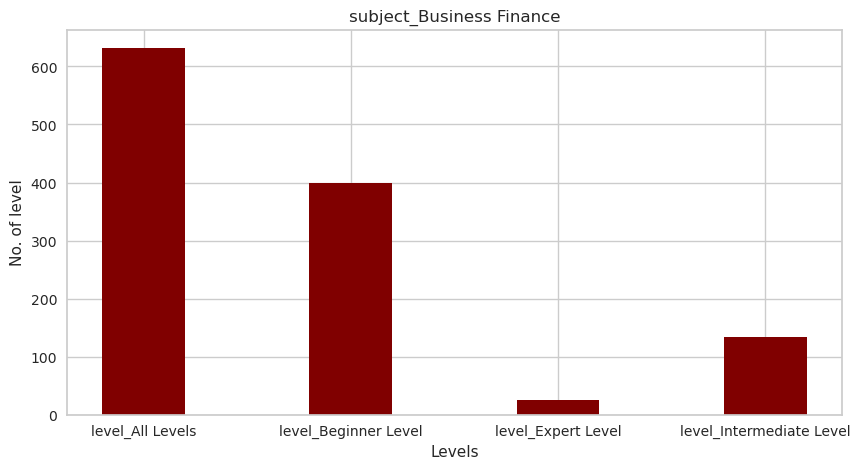

 for s = subject_Graphic Design  level= level_All Levels  num= 335
 for s = subject_Graphic Design  level= level_Beginner Level  num= 184
 for s = subject_Graphic Design  level= level_Expert Level  num= 7
 for s = subject_Graphic Design  level= level_Intermediate Level  num= 76


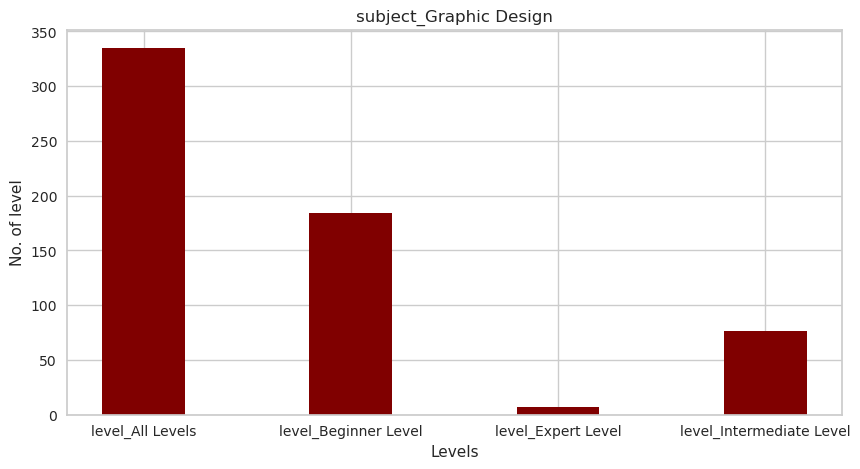

 for s = subject_Musical Instruments  level= level_All Levels  num= 324
 for s = subject_Musical Instruments  level= level_Beginner Level  num= 266
 for s = subject_Musical Instruments  level= level_Expert Level  num= 12
 for s = subject_Musical Instruments  level= level_Intermediate Level  num= 78


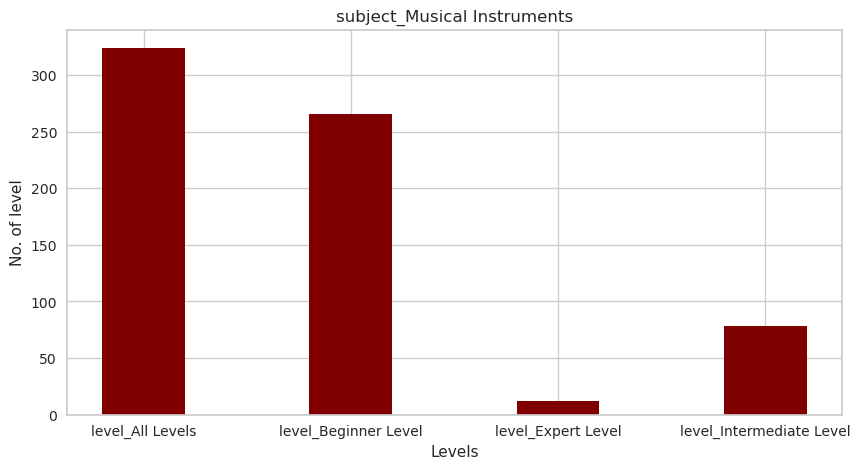

 for s = subject_Web Development  level= level_All Levels  num= 633
 for s = subject_Web Development  level= level_Beginner Level  num= 422
 for s = subject_Web Development  level= level_Expert Level  num= 14
 for s = subject_Web Development  level= level_Intermediate Level  num= 134


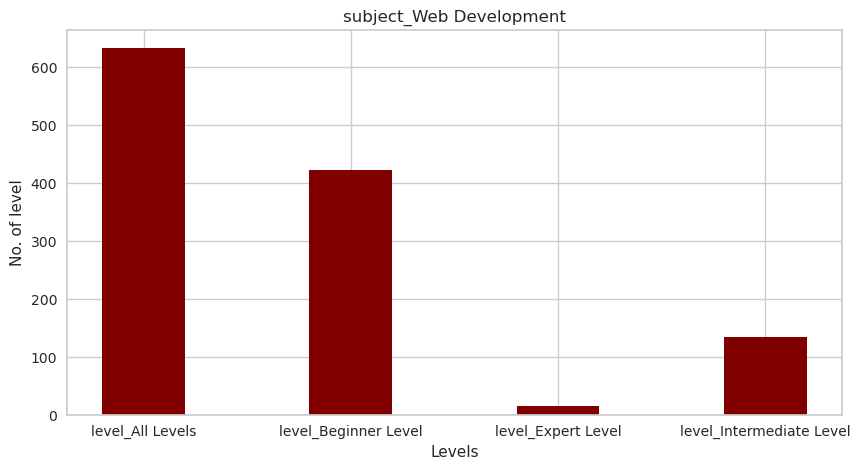

3675


In [35]:
c=0
for s in sub:
    maximume=0
    sStr=-1
    lStr=-1
    d=[]
    for l in lev:
        
        res=np.where((df_Gragh[s]==1) &(df_Gragh[l]==1),1,0)
        d.append(np.sum( res))
        print(" for s =",s," level=",l," num=",np.sum( res))
        c+=np.sum( res)
        if np.sum( res)>maximume:
            sStr=s
            lStr=l
            maximume=np.sum( res)
    fig = plt.figure(figsize = (10, 5))
    plt.bar(lev, d, color ='maroon',
            width = 0.4)
   
    plt.xlabel("Levels")
    plt.ylabel("No. of level")
    plt.title(s)
    plt.show()
print(c)

2-What is the average rating for each subject?
avarage rate for  subject_Business Finance  is  0.6901344537815126
avarage rate for  subject_Graphic Design  is  0.7303820598006644
avarage rate for  subject_Musical Instruments  is  0.30891176470588233
avarage rate for  subject_Web Development  is  0.643050706566916

avarage rate for  subject_Business Finance  is  0.6901344537815126
avarage rate for  subject_Graphic Design  is  0.7303820598006644
avarage rate for  subject_Musical Instruments  is  0.30891176470588233
avarage rate for  subject_Web Development  is  0.643050706566916


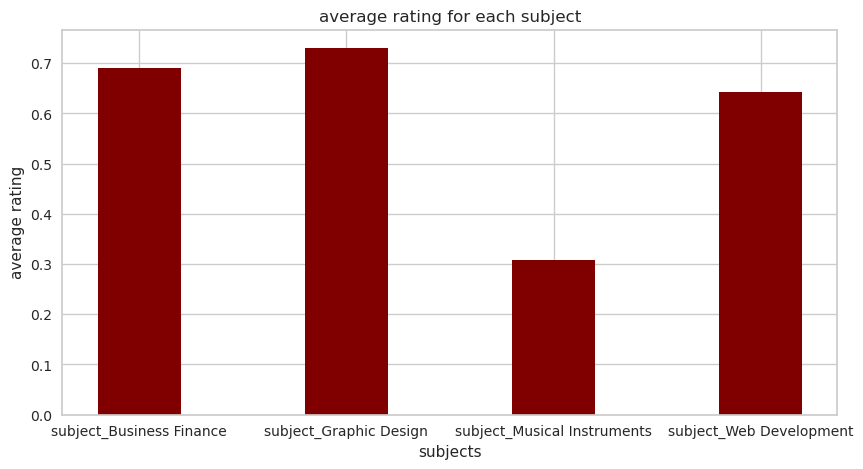

In [36]:
d=[]
for s in sub:
    
    x=df_Gragh.loc[df_Gragh[s] == 1, 'rating'].mean()
    d.append(x)
    print("avarage rate for ",s ," is ",x)
fig = plt.figure(figsize = (10, 5))
plt.bar(sub, d, color ='maroon',
        width = 0.4)

plt.xlabel("subjects")
plt.ylabel("average rating")
plt.title("average rating for each subject")
plt.show()

3.What is the relation between the number of subscribers and the publishing year of the course?
we can not notice anything from first graph  so we will use time series STL decompostion to get information 

In [37]:
df_Gragh["Year"],df_Gragh["Month"]=df_Gragh['Date'].apply(lambda x: x.year),df['Date'].apply(lambda x: x.month)


In [38]:

y=pd.unique(df_Gragh['Year'])
y=np.sort(y)
m=pd.unique(df_Gragh['Month'])
m=np.sort(m)
m

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

year= 2011  max month= 11
year= 2011  min month= 1
year= 2012  max month= 6
year= 2012  min month= 1
year= 2013  max month= 2
year= 2013  min month= 3
year= 2014  max month= 4
year= 2014  min month= 1
year= 2015  max month= 11
year= 2015  min month= 5
year= 2016  max month= 3
year= 2016  min month= 7
year= 2017  max month= 2
year= 2017  min month= 1


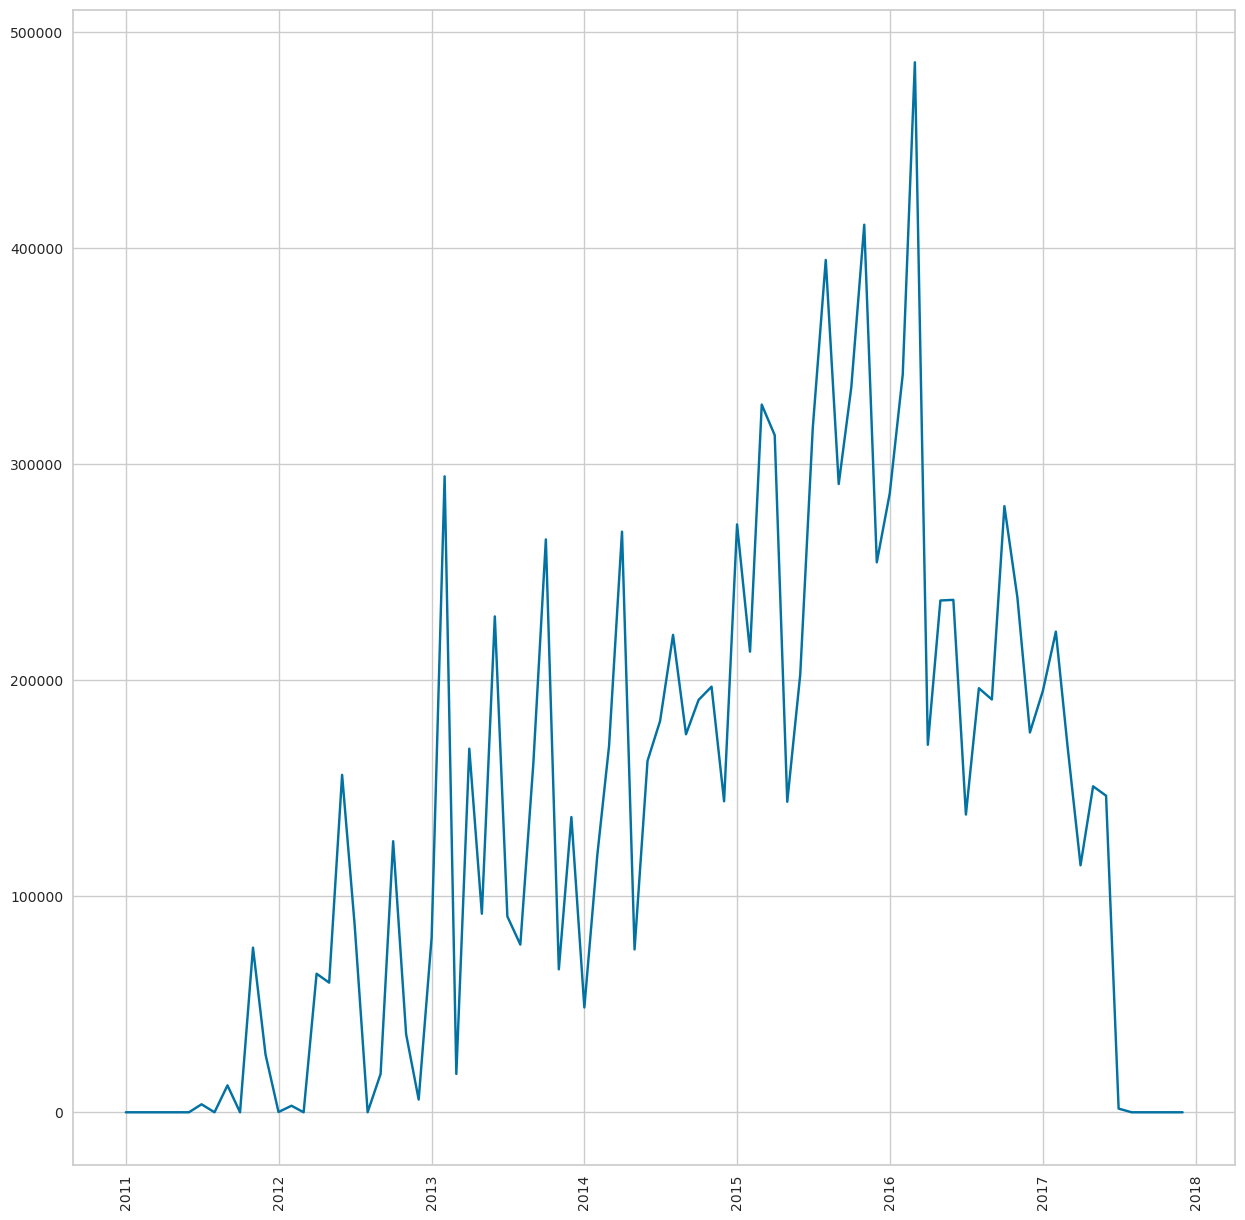

In [39]:
import datetime
numOfSubs=[]
monthes=[]
for Y in y:
    for i,M in enumerate(m):
        sumOfMonth=df_Gragh.loc[(df_Gragh["Year"] == Y) & (df_Gragh["Month"]==M), 'num_subscribers'].sum()
        numOfSubs.append(sumOfMonth)
        monthes.append(datetime.date(Y, M,1))
        
   
for i,Y in enumerate(y):
    print("year=", Y, " max month=",(numOfSubs.index(np.max(numOfSubs[i*12:i*12+11]))%12)+1)
    print("year=", Y, " min month=",(numOfSubs.index(np.min(numOfSubs[i*12:i*12+11]))%12)+1)
plt.figure(figsize=(15,15))        
plt.plot(monthes, numOfSubs)

plt.xticks(rotation = 90)
plt.show()

we notice trend in 2016 and also increase subscribers every year but in 2017 down why?????

In [40]:
from statsmodels.tsa.seasonal import STL
dataFrameRel= pd.DataFrame(
    numOfSubs,index=monthes
)

print(dataFrameRel.sample(5))


                 0
2017-12-01       0
2011-01-01       0
2014-05-01   75374
2012-04-01   64127
2015-10-01  335447


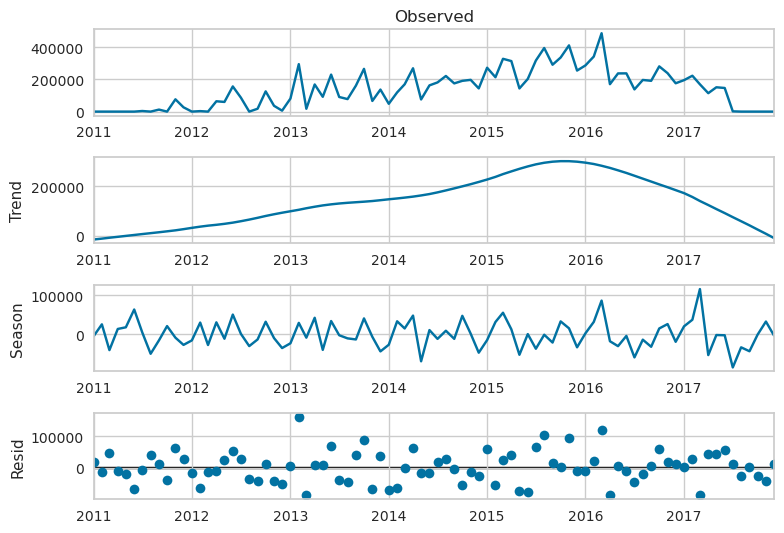

In [41]:
stl = STL(dataFrameRel, period=12)
res = stl.fit()
fig = res.plot()

becuase max date is 6/7/2017  we didnot have information about last 5 months 

In [42]:

df_Gragh["Date"].max()

datetime.date(2017, 7, 6)

In [43]:
df_Gragh.sample(5)

,price,num_subscribers,num_reviews,num_lectures,rating,content_duration,level_All Levels,level_Beginner Level,level_Expert Level,level_Intermediate Level,subject_Business Finance,subject_Graphic Design,subject_Musical Instruments,subject_Web Development,Date,Year,Month
1547,85,1235,46,131,0.01,7.5,0,1,0,0,0,0,1,0,2013-06-10,2013,6
132,60,16385,273,45,0.78,3.0,0,1,0,0,1,0,0,0,2014-09-02,2014,9
601,20,4497,281,11,0.80,1.0,1,0,0,0,1,0,0,0,2015-07-14,2015,7
1479,0,1318,7,27,0.47,2.0,0,1,0,0,1,0,0,0,2016-08-24,2016,8
595,100,4537,415,49,0.89,9.0,0,1,0,0,0,0,0,1,2015-08-20,2015,8


we have three types of hypothesis test first category and category columns ,second numerical and category columns and third numerical and numerical columns
numerical and numerical columns:
the Spearman rank correlation coefficient measures the strength and direction of the monotonic relationship between X and Y. The p-value indicates the probability of observing a correlation coefficient as extreme as the one computed, assuming that there is no monotonic relationship between X and Y. If the p-value is less than the chosen significance level (e.g., 0.05), you can reject the null hypothesis that there is no monotonic relationship between X and Y.
numerical and category columns :
f_oneway test  
if p_val < 0.05:
    print("There is a significant difference in the mean price across different levels")
else:
    print("There is no significant difference in the mean price across different levels")
there is no category and category columns in questions



**note:correlation detect only linear relation**


4.What is the relation between the course level and the course price?
here category and numerical columns so we will use f_one way test 
and this test tell us if probability < .05 so its different but if >.05 there is relation.

In [44]:
import pandas as pd
from scipy.stats import f_oneway



# Group the data by category
groups = df.groupby("level")["price"].apply(list)
print(groups)
# # Calculate the means and standard deviations of the price for each category
# means = groups.mean()
# stds = groups.std()

# Perform One-Way ANOVA
f_stat, p_val = f_oneway(*groups)
print(p_val)

if p_val < 0.05:
    print("There is a significant difference in the mean price across different levels")
else:
    print("There is no significant difference in the mean price across different levels")


level
All Levels            [0, 0, 0, 30, 175, 0, 0, 0, 120, 0, 0, 195, 0, 145, 0, 180, 0, 50, 0, 0, 195, 0, 150, ...
Beginner Level        [0, 200, 200, 200, 190, 0, 175, 195, 0, 0, 0, 75, 195, 50, 200, 20, 195, 195, 20, 0, 1...
Expert Level          [0, 150, 50, 0, 0, 185, 125, 20, 120, 20, 20, 20, 0, 50, 0, 95, 200, 30, 200, 0, 25, 5...
Intermediate Level    [0, 195, 195, 195, 0, 0, 0, 190, 200, 100, 150, 0, 150, 20, 195, 195, 100, 195, 195, 5...
Name: price, dtype: object
0.6634652659006761
There is no significant difference in the mean price across different levels


0.3301236583092444


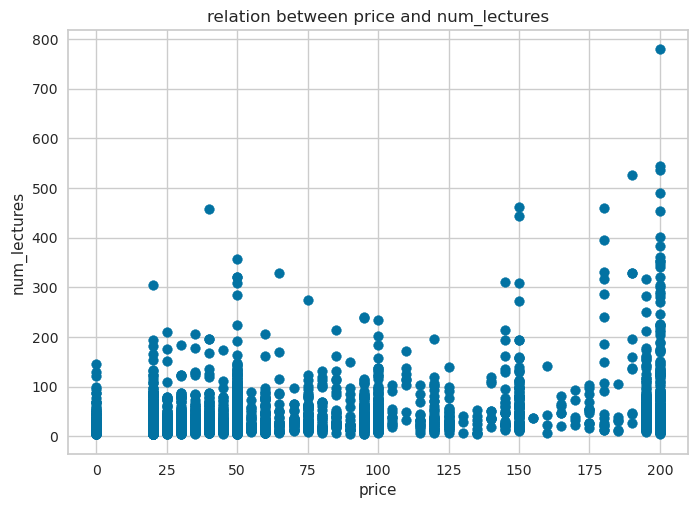

Spearman rank correlation coefficient: 0.3868
P-value: 0.0000


In [45]:
print(df["price"]. corr(df["num_lectures"]) )
plt.scatter(df["price"],df["num_lectures"])
plt.xlabel("price")
plt.ylabel("num_lectures")
plt.title("relation between price and num_lectures")
plt.show()
corr_coef, p_val = spearmanr(df["price"],df["num_lectures"])

print(f"Spearman rank correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {p_val:.4f}")

5.What is the relation between the rating with the number of reviews and subscribers?
if we have two numerical cloumns we use ttest and also we can use correlation 
so we will do that for all combination between rating ,
number of reviews and subscribers:
we see relation between number of reviews and subscribers because correlation = .65
and also spearmanr test p-value=0 and that tell us there is relation 

number of reviews and rating:

we see no relation between number of reviews and rating use correlation = 0.004184210818520607
and also spearmanr test p-value=.67 and that tell us there is no relation 

number of subscribers and rating:

we see no relation between number of subscribers and rating use correlation = -0.00726145411559383
and also spearmanr test p-value=.33and that tell us there is no relation 

0.004184210818520607


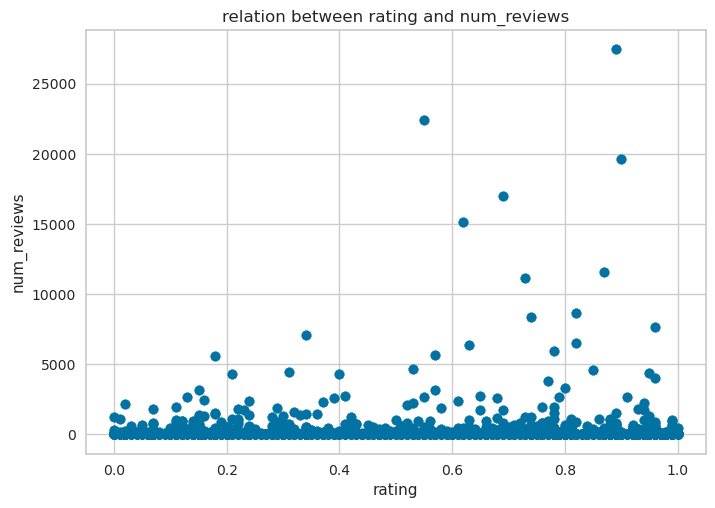

Spearman rank correlation coefficient: -0.0070
P-value: 0.6715


In [46]:
print(df["rating"]. corr(df["num_reviews"]) )
plt.scatter(df["rating"],df["num_reviews"])
plt.xlabel("rating")
plt.ylabel("num_reviews")
plt.title("relation between rating and num_reviews")
plt.show()
corr_coef, p_val = spearmanr(df["rating"],df["num_reviews"])

print(f"Spearman rank correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {p_val:.4f}")



-0.00726145411559383


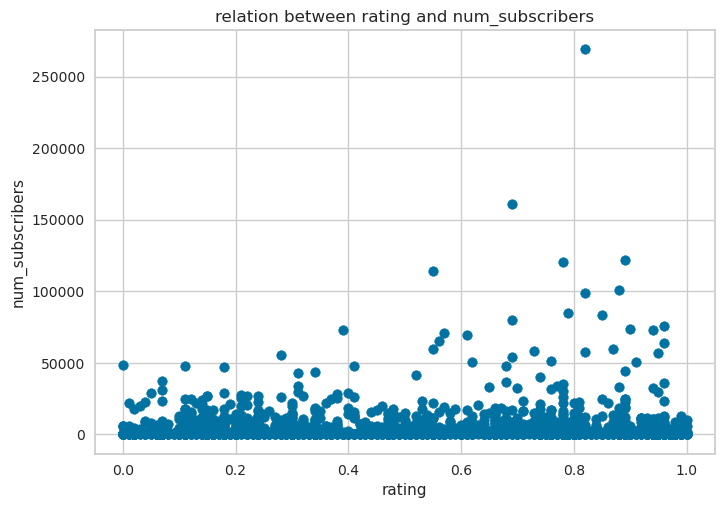

Spearman rank correlation coefficient: 0.0160
P-value: 0.3308


In [47]:
print(df["rating"]. corr(df["num_subscribers"]) )
plt.scatter(df["rating"],df["num_subscribers"])
plt.xlabel("rating")
plt.ylabel("num_subscribers")
plt.title("relation between rating and num_subscribers")
plt.show()
corr_coef, p_val = spearmanr(df["rating"],df["num_subscribers"])

print(f"Spearman rank correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {p_val:.4f}")

0.650758021982771


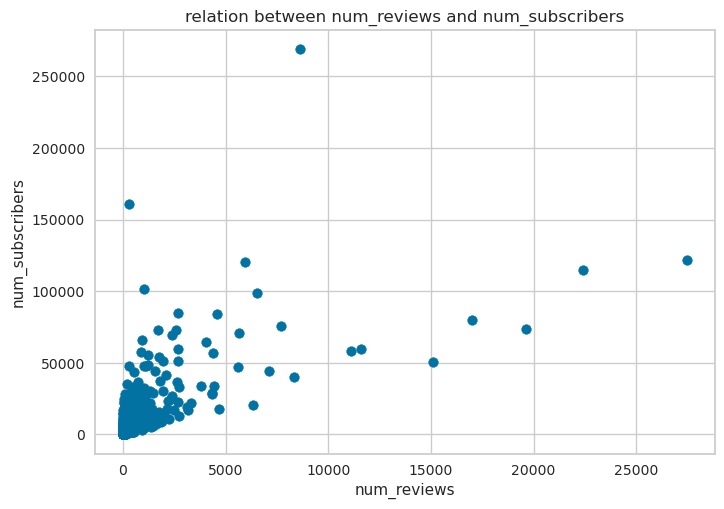

Spearman rank correlation coefficient: 0.7842
P-value: 0.0000


In [48]:
print(df["num_reviews"]. corr(df["num_subscribers"]) )
plt.scatter(df["num_reviews"],df["num_subscribers"])
plt.xlabel("num_reviews")
plt.ylabel("num_subscribers")
plt.title("relation between num_reviews and num_subscribers")
plt.show()
corr_coef, p_val = spearmanr(df["num_reviews"],df["num_subscribers"])

print(f"Spearman rank correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {p_val:.4f}")

9.does the increase of price affect number of subscribers?
from correlation we see there is no relation 

0.05049026882856973


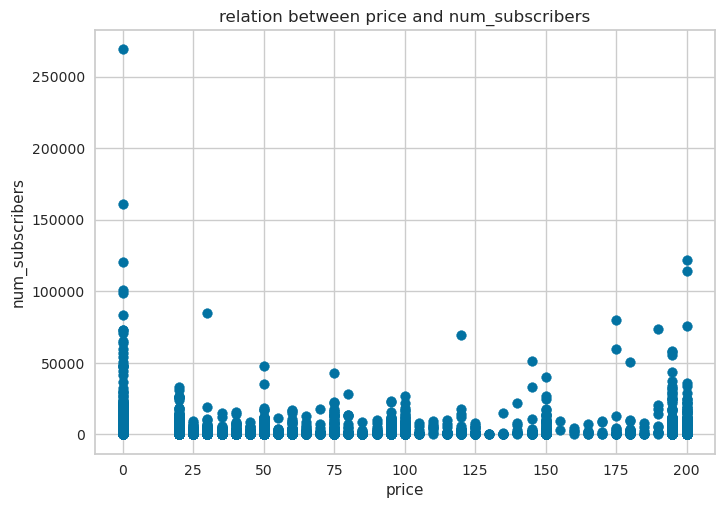

Spearman rank correlation coefficient: 0.7842
P-value: 0.0000


In [49]:
print(df["price"]. corr(df["num_subscribers"]) )
plt.scatter(df["price"],df["num_subscribers"])

plt.xlabel("price")
plt.ylabel("num_subscribers")
plt.title("relation between price and num_subscribers")
plt.show()
corr_coef, p_val = spearmanr(df["num_reviews"],df["num_subscribers"])
print(f"Spearman rank correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {p_val:.4f}")

10.does the subject affect the duration? 


f_oneway test  p-value=0 then there is relation

In [50]:
import pandas as pd
from scipy.stats import f_oneway



# Group the data by category
groups = df.groupby("subject")["content_duration"].apply(list)
print(groups)


# Perform One-Way ANOVA
f_stat, p_val = f_oneway(*groups)
print(p_val)

if p_val < 0.05:
    print("There is a significant difference in the mean subject across different content_duration")
else:
    print("There is no significant difference in the mean subject across different content_duration")


subject
Business Finance       [8.0, 1.5, 1.5, 1.5, 10.0, 3.5, 7.5, 16.0, 1.5, 2.0, 1.0, 1.0, 5.5, 3.0, 2.5, 1.0, 11....
Graphic Design         [4.5, 2.5, 7.5, 5.0, 0.7, 11.0, 1.0, 1.5, 0.7333333333, 1.0, 3.5, 68.5, 8.0, 3.0, 2.5,...
Musical Instruments    [4.5, 30.0, 4.0, 34.0, 2.5, 9.5, 0.6666666667, 2.0, 2.0, 5.0, 1.5, 2.0, 1.5, 15.5, 1.5...
Web Development        [10.5, 3.5, 43.0, 3.0, 30.5, 3.0, 2.0, 6.5, 11.5, 22.0, 2.0, 1.0, 6.0, 27.5, 1.5, 4.5,...
Name: content_duration, dtype: object
3.7154955176037283e-25
There is a significant difference in the mean subject across different content_duration


11.does the number of lectures and the duration affect the number of subscribers?
correlation = .8 
and p-value = 0
then there is high relation between content_duration and num_lectures 
and also  num_subscribers and content_duration 
and also num_lectures and  num_subscribers 
because p-value =0 but correlation not high why ???????
becuause correltion detect only linear relation but test detect prabola and .....

0.8016021979065878


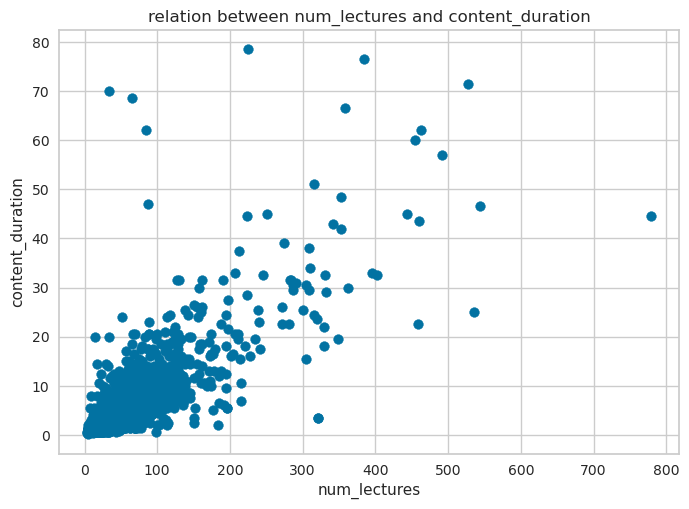

Spearman rank correlation coefficient: 0.8052
P-value: 0.0000


In [51]:
print(df["num_lectures"]. corr(df["content_duration"]) )
plt.scatter(df["num_lectures"],df["content_duration"])
corr_coef, p_val = spearmanr(df["num_lectures"],df["content_duration"])
plt.xlabel("num_lectures")
plt.ylabel("content_duration")
plt.title("relation between num_lectures and content_duration")
plt.show()
print(f"Spearman rank correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {p_val:.4f}")

0.15803514144222297


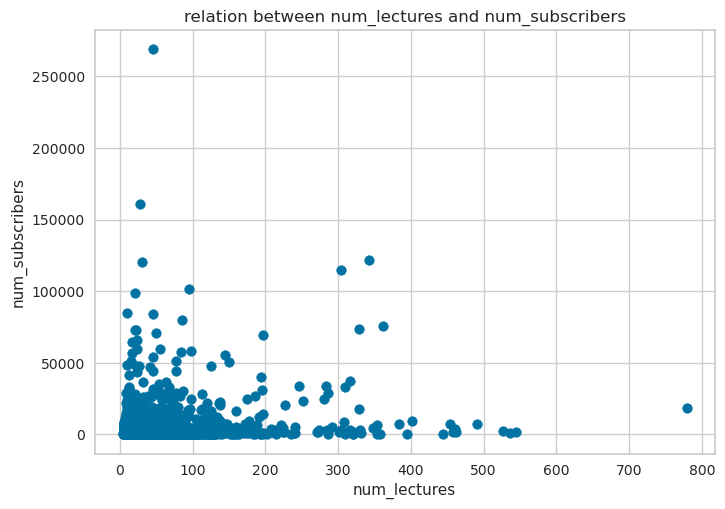

Spearman rank correlation coefficient: 0.2082
P-value: 0.0000


In [52]:
print(df["num_lectures"]. corr(df["num_subscribers"]) )
plt.scatter(df["num_lectures"],df["num_subscribers"])
plt.xlabel("num_lectures")
plt.ylabel("num_subscribers")
plt.title("relation between num_lectures and num_subscribers")
plt.show()
corr_coef, p_val = spearmanr(df["num_lectures"],df["num_subscribers"])

print(f"Spearman rank correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {p_val:.4f}")

0.16179429950386767


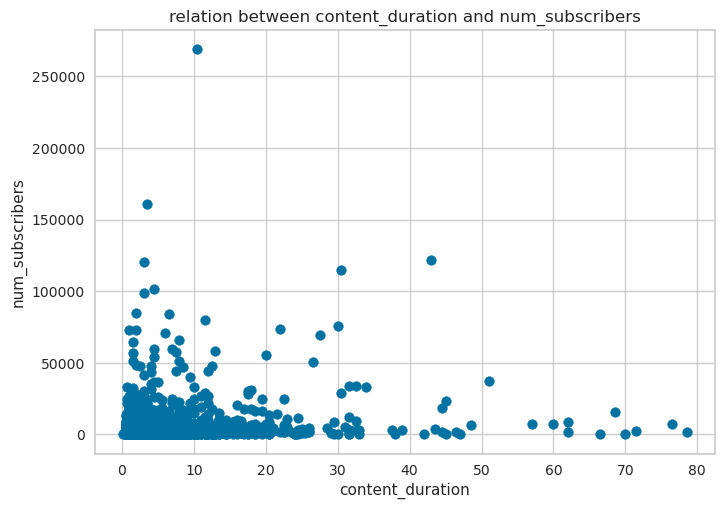

Spearman rank correlation coefficient: 0.1673
P-value: 0.0000


In [53]:
print(df["content_duration"]. corr(df["num_subscribers"]) )
plt.scatter(df["content_duration"],df["num_subscribers"])
plt.xlabel("content_duration")
plt.ylabel("num_subscribers")
plt.title("relation between content_duration and num_subscribers")
plt.show()
corr_coef, p_val = spearmanr(df["content_duration"],df["num_subscribers"])

print(f"Spearman rank correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {p_val:.4f}")

In [54]:
df.sample(5)

,price,num_subscribers,num_reviews,num_lectures,level,rating,content_duration,subject,Date
51,0,29990,1342,87,Beginner Level,0.95,17.5,Web Development,2014-08-10
1166,100,1853,34,39,Beginner Level,0.24,2.0,Web Development,2015-07-12
1202,20,1777,11,23,Beginner Level,0.23,1.0,Business Finance,2014-12-17
3673,90,0,0,12,Intermediate Level,0.36,1.0,Business Finance,2017-02-08
1691,200,1076,15,15,All Levels,0.42,1.0,Graphic Design,2017-05-22


In [55]:
#mech
import pandas as pd
from scipy.stats import f_oneway



# Group the data by category
groups = df.groupby("subject")["num_subscribers"].apply(list)
print(groups)
# # Calculate the means and standard deviations of the price for each category
# means = groups.mean()
# stds = groups.std()

# Perform One-Way ANOVA
f_stat, p_val = f_oneway(*groups)
print(p_val)

if p_val < 0.05:
    print("There is a significant difference in the mean price across different levels")
else:
    print("There is no significant difference in the mean price across different levels")

subject
Business Finance       [65576, 56659, 50855, 29167, 24481, 22344, 22257, 20195, 19614, 19339, 17847, 17160, 1...
Graphic Design         [53851, 47811, 44044, 36288, 33205, 26742, 25277, 24857, 24687, 23229, 18303, 15500, 1...
Musical Instruments    [101154, 75499, 47652, 32935, 26504, 21701, 14922, 14560, 14495, 10869, 10435, 9351, 9...
Web Development        [268923, 161029, 121584, 120291, 114512, 98867, 84897, 83737, 79612, 73783, 73110, 729...
Name: num_subscribers, dtype: object
2.000271753034786e-52
There is a significant difference in the mean price across different levels


12.How does the increase or decrease in the course rating affect the course’s price?
correlation =0  and p-value=.4 then there is no relation

0.03185815857449583


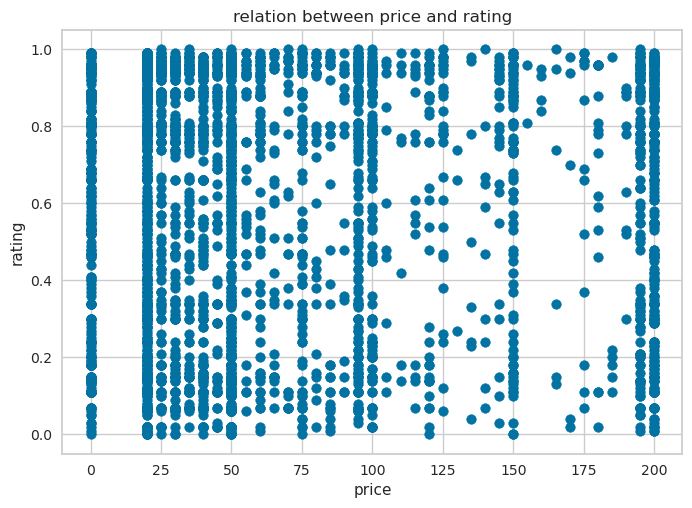

Spearman rank correlation coefficient: 0.0131
P-value: 0.4270


In [56]:
#mach
print(df["price"]. corr(df["rating"]) )
plt.scatter(df["price"],df["rating"]) 
plt.xlabel("price")
plt.ylabel("rating")
plt.title("relation between price and rating")
plt.show()
corr_coef, p_val = spearmanr(df["price"],df["rating"])

print(f"Spearman rank correlation coefficient: {corr_coef:.4f}")
print(f"P-value: {p_val:.4f}")

In [57]:
df_Gragh.sample(5)

,price,num_subscribers,num_reviews,num_lectures,rating,content_duration,level_All Levels,level_Beginner Level,level_Expert Level,level_Intermediate Level,subject_Business Finance,subject_Graphic Design,subject_Musical Instruments,subject_Web Development,Date,Year,Month
1262,120,1678,34,32,0.28,2.5,1,0,0,0,0,0,0,1,2016-02-03,2016,2
98,0,19909,411,17,0.46,3.0,1,0,0,0,0,0,0,1,2014-02-12,2014,2
2074,20,605,21,11,0.07,0.7,0,0,0,1,0,0,1,0,2015-07-28,2015,7
1401,20,1442,9,25,0.78,2.0,1,0,0,0,0,0,0,1,2015-01-23,2015,1
1173,195,1839,91,47,0.60,5.0,1,0,0,0,0,0,0,1,2016-06-20,2016,6


In [58]:
df_Gragh.drop('Date',axis=1,inplace=True)
df_Gragh.drop('Year',axis=1,inplace=True)
df_Gragh.drop('Month',axis=1,inplace=True)

In [59]:
df_Gragh.sample(5)

,price,num_subscribers,num_reviews,num_lectures,rating,content_duration,level_All Levels,level_Beginner Level,level_Expert Level,level_Intermediate Level,subject_Business Finance,subject_Graphic Design,subject_Musical Instruments,subject_Web Development
3266,50,17,1,12,0.38,1.0,0,1,0,0,0,1,0,0
1000,20,2283,54,16,0.96,2.0,0,0,0,1,1,0,0,0
2415,200,294,19,42,0.78,7.0,1,0,0,0,1,0,0,0
1112,70,2002,34,33,0.38,4.0,1,0,0,0,0,0,1,0
1009,30,2266,26,10,0.59,1.0,0,1,0,0,0,1,0,0


**there is problem in data which is for analyis only not to predict so randomness in data so much ,so error not the best**

6.What will be the price for a new course?
7.What will be the number of subscribers to a new course in a curtain subject?
8.What will be the rating of a new course?
we use more than one classifier to get the best classifier but still bad that is becuase no relation between (price or rating or number of subscribers) and all feature and also randomness




for col in df_Gragh.columns:
    print(col)
    plt.scatter(df_Gragh["price"],df_Gragh[col])
    plt.show()

price


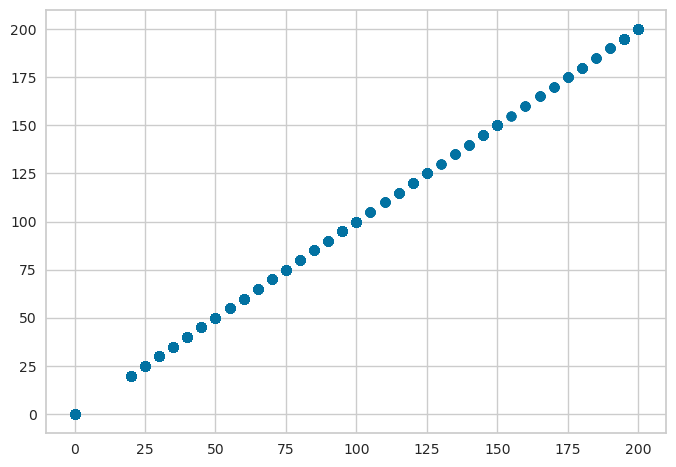

num_subscribers


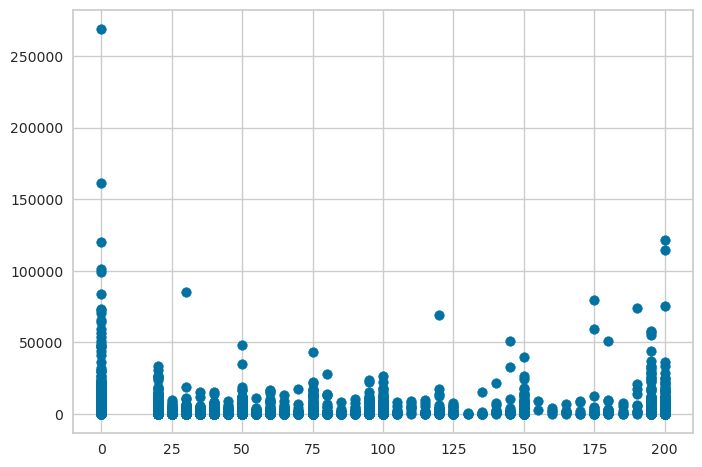

num_reviews


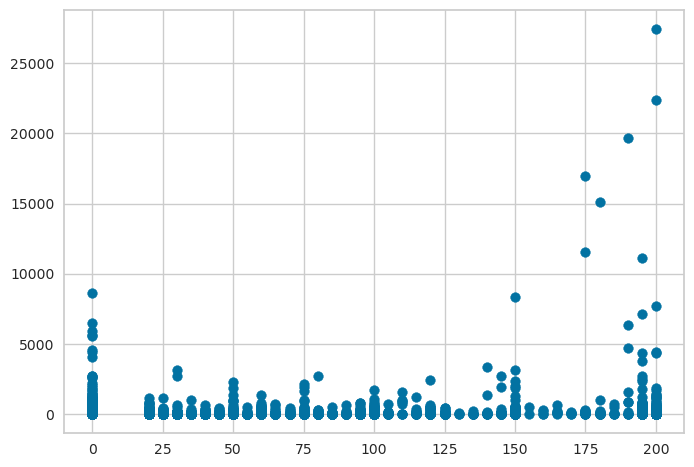

num_lectures


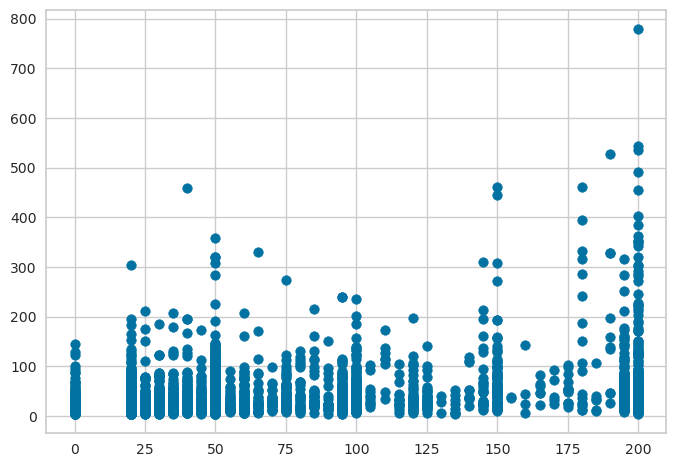

rating


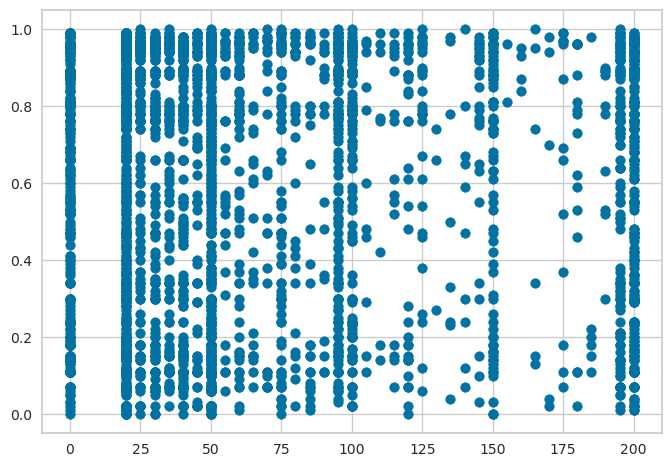

content_duration


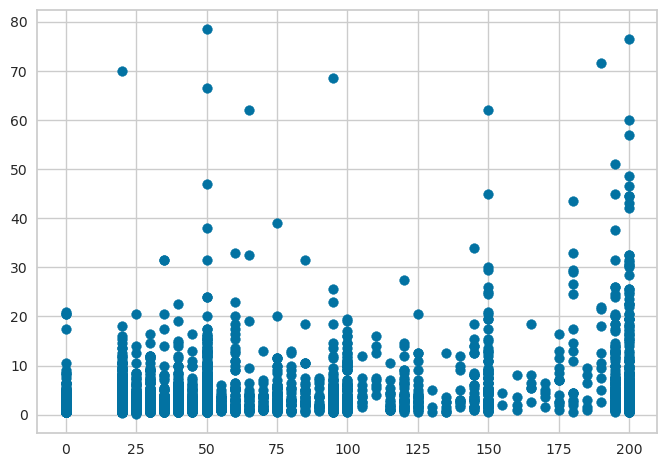

level_All Levels


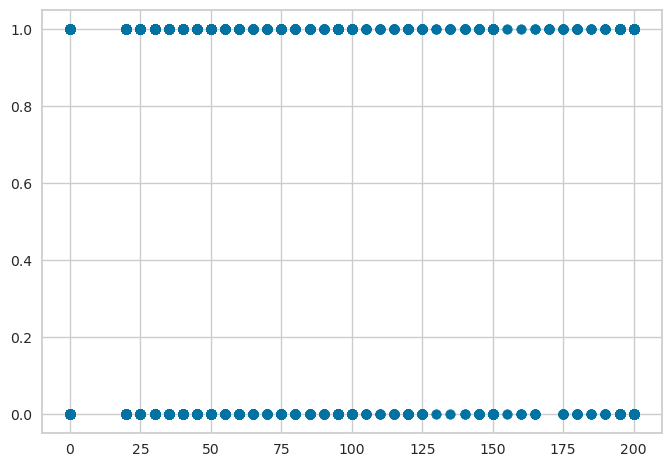

level_Beginner Level


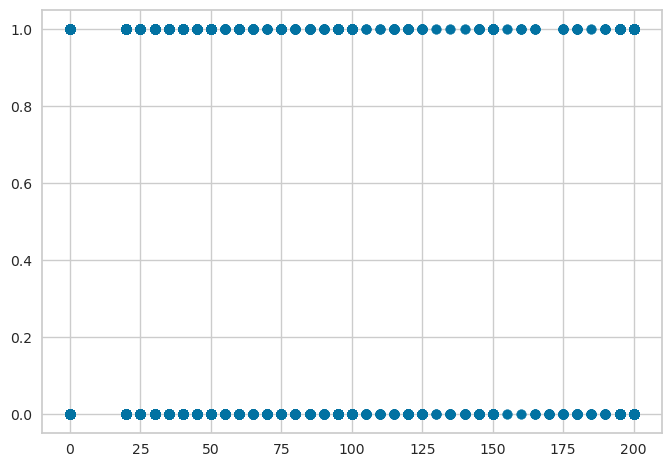

level_Expert Level


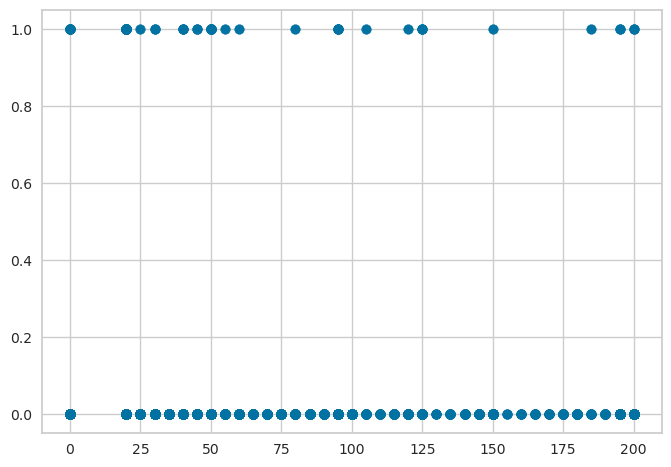

level_Intermediate Level


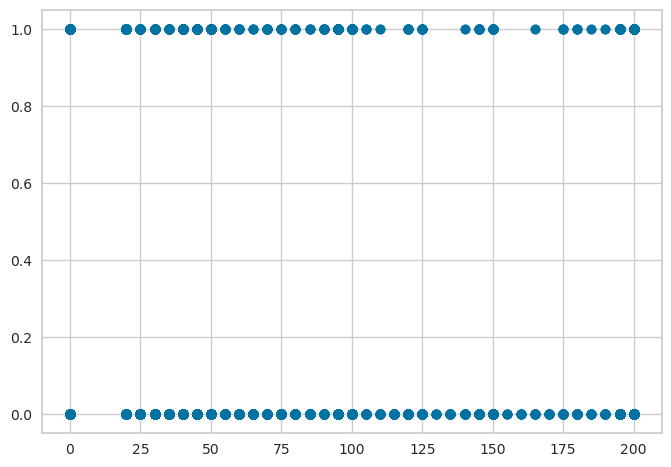

subject_Business Finance


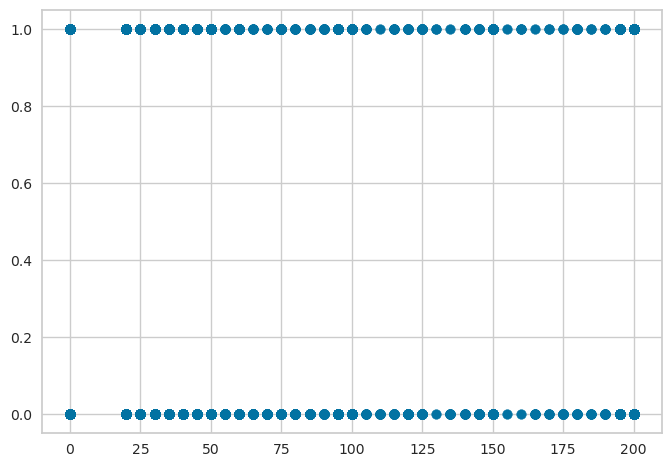

subject_Graphic Design


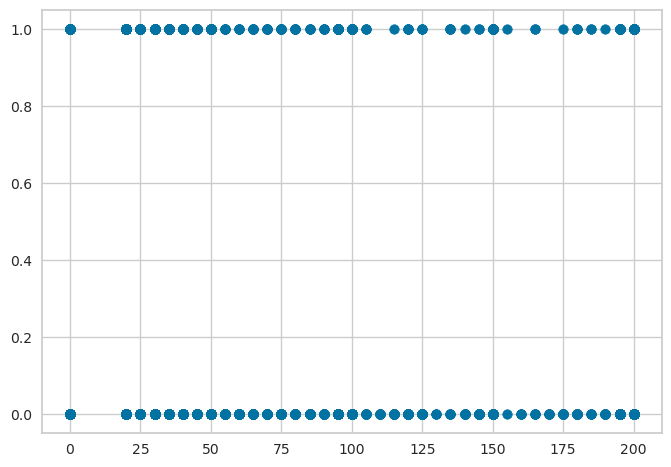

subject_Musical Instruments


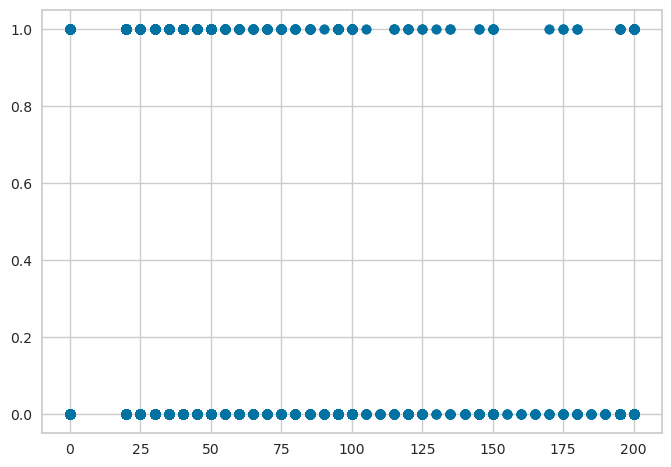

subject_Web Development


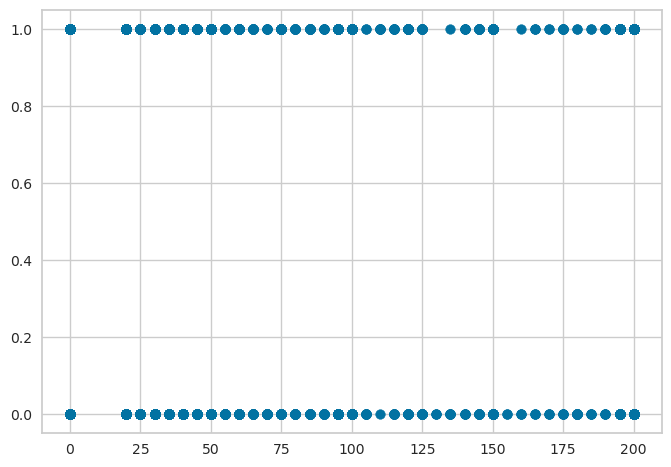

In [60]:
for col in df_Gragh.columns:
    print(col)
    plt.scatter(df_Gragh["price"],df_Gragh[col])
    plt.show()

In [61]:
X=df_Gragh.iloc[:,:].copy()
Y=df_Gragh["price"].copy()
print(len(Y))
X=X.drop(["price"],axis=1)
X.columns

3675


Index(['num_subscribers', 'num_reviews', 'num_lectures', 'rating',
       'content_duration', 'level_All Levels', 'level_Beginner Level',
       'level_Expert Level', 'level_Intermediate Level',
       'subject_Business Finance', 'subject_Graphic Design',
       'subject_Musical Instruments', 'subject_Web Development'],
      dtype='object')

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=412)

In [63]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from xgboost import XGBRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor

In [64]:
steps = [
    ('power_transformer', PowerTransformer()),
    ('regressor', XGBRegressor(n_estimators=350))
]

# create the pipeline
pipeline = Pipeline(steps=steps)

# fit the pipeline on X_train and y_train
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
print(math.sqrt(mean_squared_error(y_train, y_pred)))
# Predict on the test data
y_pred = pipeline.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred)))

4.568382147825764
64.67099655379562


In [65]:


steps = [
    ('power_transformer', PowerTransformer()),
    ('Ridge',Ridge(alpha=.001))
]

# create the pipeline
pipeline = Pipeline(steps=steps)

# fit the pipeline on X_train and y_train
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
print(math.sqrt(mean_squared_error(y_train, y_pred)))
# Predict on the test data
y_pred = pipeline.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred)))

55.964739992261386
57.2845652316694


In [66]:



steps = [
    ('power_transformer', PowerTransformer()),
    ('lasso',Lasso(alpha=.5))
]

# create the pipeline
pipeline = Pipeline(steps=steps)

# fit the pipeline on X_train and y_train
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
print(math.sqrt(mean_squared_error(y_train, y_pred)))
# Predict on the test data
y_pred = pipeline.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred)))

55.97885181836227
57.31447517173887


In [67]:
steps = [
    ('power_transformer', PowerTransformer()),
    ('DecisionTree',DecisionTreeRegressor())
]

# create the pipeline
pipeline = Pipeline(steps=steps)

# fit the pipeline on X_train and y_train
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
print(math.sqrt(mean_squared_error(y_train, y_pred)))
# Predict on the test data
y_pred = pipeline.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred)))

0.36888344018168967
76.39419722443071


In [68]:
steps = [
    ('power_transformer', PowerTransformer()),
    ('RandomForest',RandomForestRegressor())
]

# create the pipeline
pipeline = Pipeline(steps=steps)

# fit the pipeline on X_train and y_train
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
print(math.sqrt(mean_squared_error(y_train, y_pred)))
# Predict on the test data
y_pred = pipeline.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred)))

20.968577734131596
58.05079490758222


price


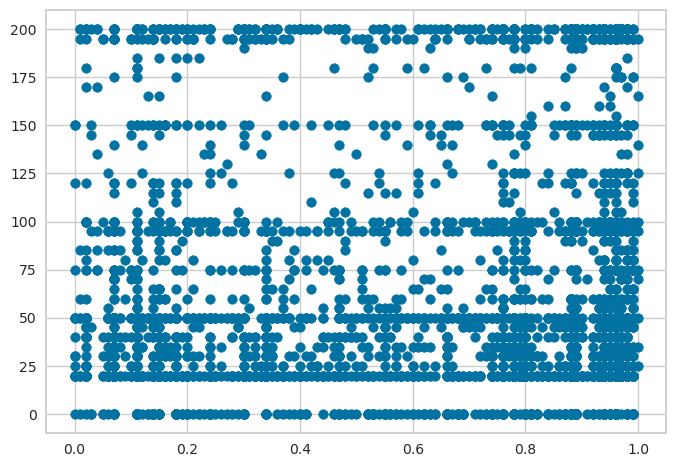

num_subscribers


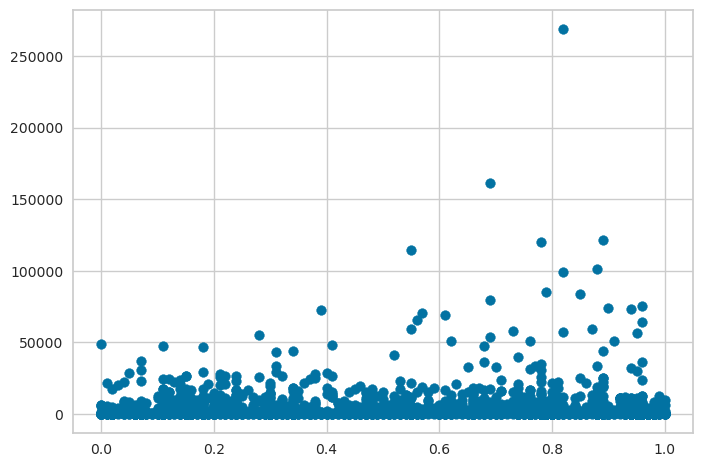

num_reviews


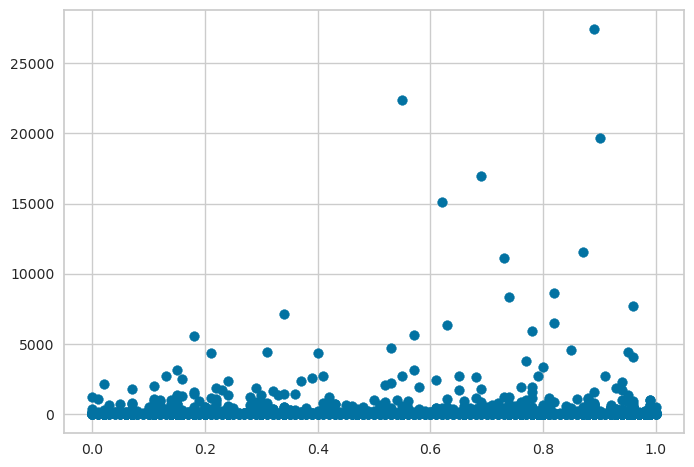

num_lectures


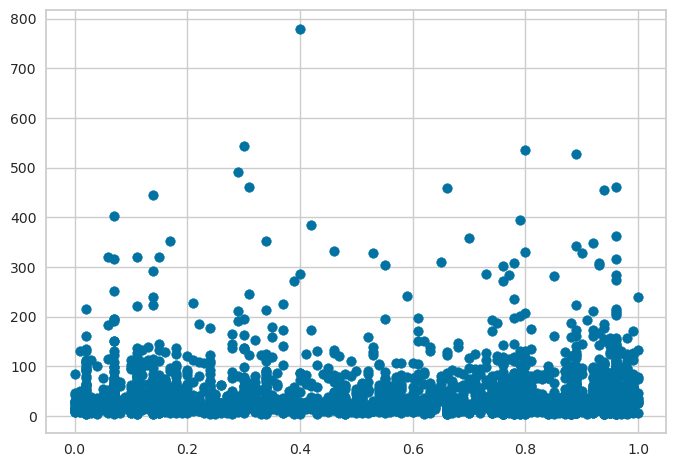

rating


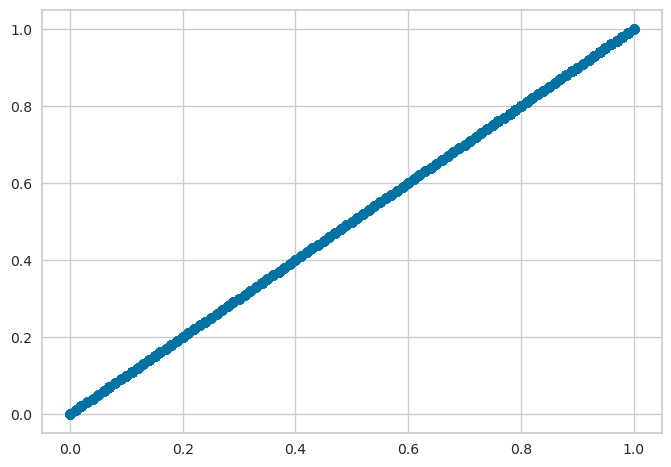

content_duration


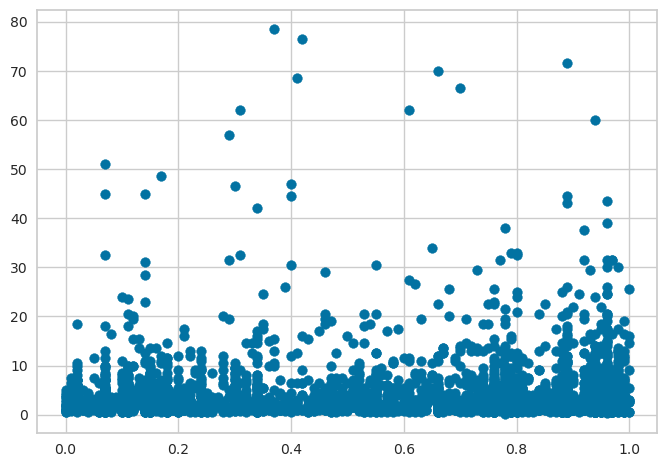

level_All Levels


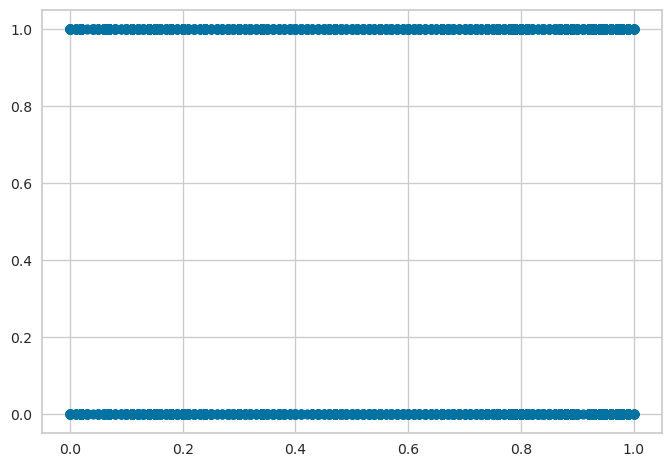

level_Beginner Level


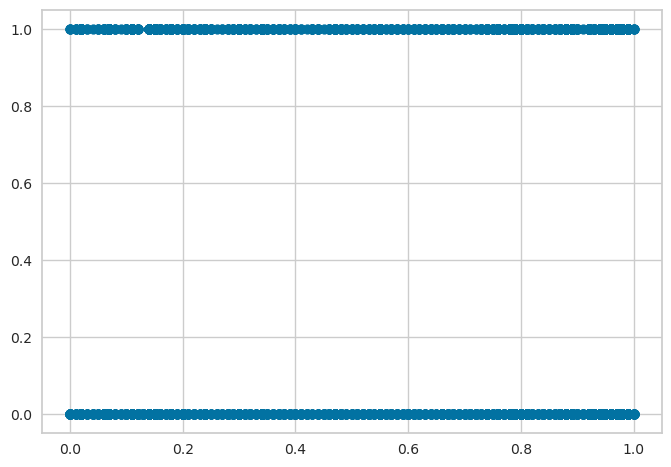

level_Expert Level


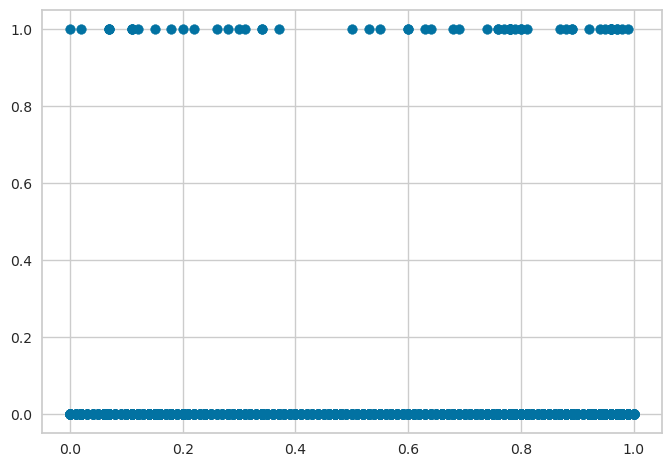

level_Intermediate Level


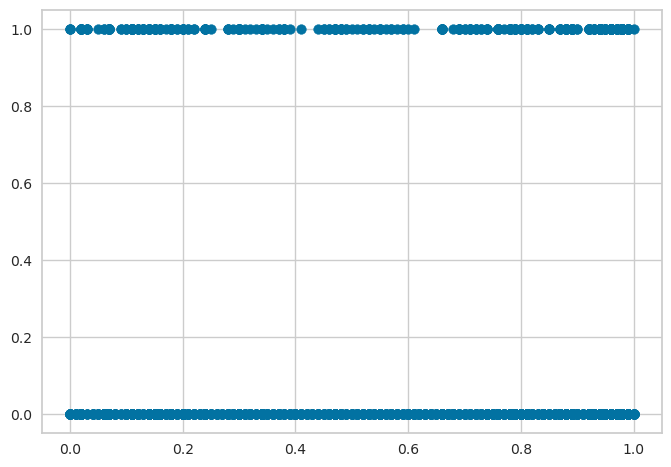

subject_Business Finance


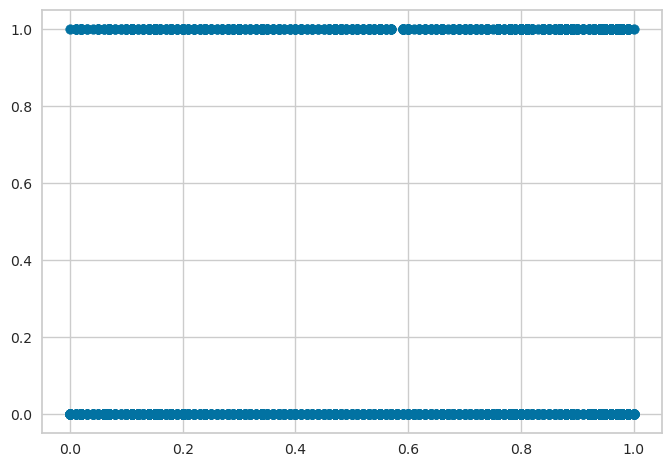

subject_Graphic Design


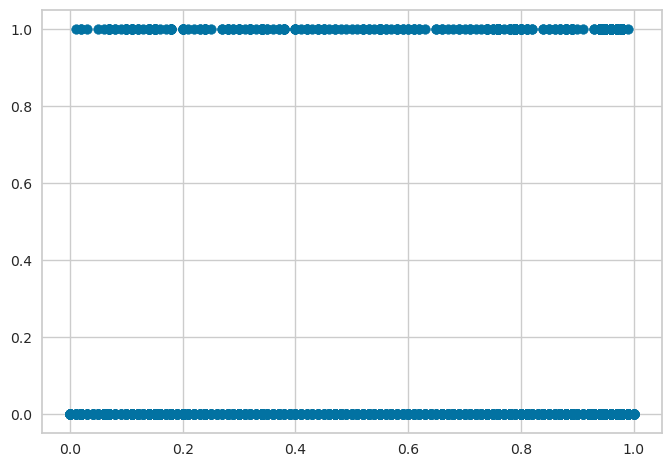

subject_Musical Instruments


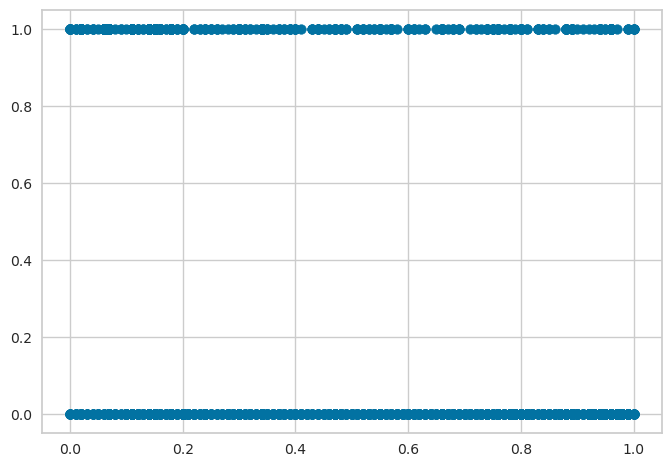

subject_Web Development


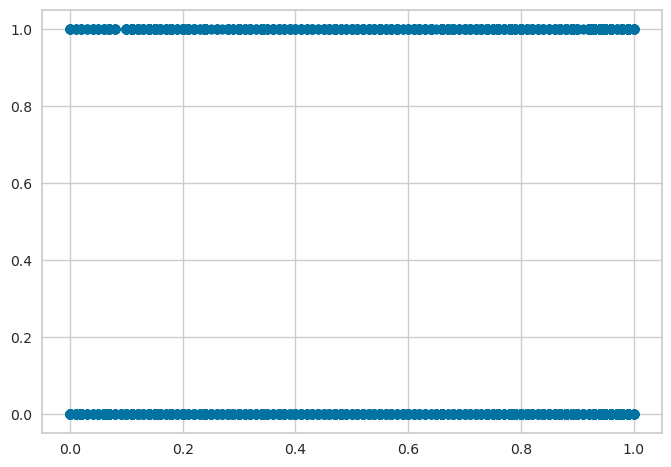

In [69]:
for col in df_Gragh.columns:
    print(col)
    plt.scatter(df_Gragh["rating"],df_Gragh[col])
    plt.show()

In [70]:
X=df_Gragh.iloc[:,:].copy()
Y=df_Gragh["rating"].copy()
print(len(Y))
X=X.drop(["rating"],axis=1)
X.columns

3675


Index(['price', 'num_subscribers', 'num_reviews', 'num_lectures',
       'content_duration', 'level_All Levels', 'level_Beginner Level',
       'level_Expert Level', 'level_Intermediate Level',
       'subject_Business Finance', 'subject_Graphic Design',
       'subject_Musical Instruments', 'subject_Web Development'],
      dtype='object')

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=412)

In [72]:
steps = [
    ('power_transformer', PowerTransformer()),
    ('regressor', XGBRegressor(n_estimators=350))
]

# create the pipeline
pipeline = Pipeline(steps=steps)

# fit the pipeline on X_train and y_train
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
print(math.sqrt(mean_squared_error(y_train, y_pred)))
# Predict on the test data
y_pred = pipeline.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred)))

0.028440912808843276
0.29115951869432527


In [73]:
steps = [
    ('power_transformer', PowerTransformer()),
    ('DecisionTree',DecisionTreeRegressor(max_depth=15))
]

# create the pipeline
pipeline = Pipeline(steps=steps)

# fit the pipeline on X_train and y_train
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
print(math.sqrt(mean_squared_error(y_train, y_pred)))
# Predict on the test data
y_pred = pipeline.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred)))

0.09234824302986454
0.33128603307170235


In [74]:
df_Gragh.corr()

,price,num_subscribers,num_reviews,num_lectures,rating,content_duration,level_All Levels,level_Beginner Level,level_Expert Level,level_Intermediate Level,subject_Business Finance,subject_Graphic Design,subject_Musical Instruments,subject_Web Development
price,1.000000,0.050490,0.113398,0.330124,0.031858,0.293147,0.011154,-0.010528,-0.016823,0.004810,0.029554,-0.059720,-0.129318,0.124648
num_subscribers,0.050490,1.000000,0.650758,0.158035,-0.007261,0.161794,0.005934,0.004534,0.021750,-0.024562,-0.118888,-0.066911,-0.098197,0.252592
num_reviews,0.113398,0.650758,1.000000,0.242971,0.004184,0.228826,-0.016544,0.033363,-0.003471,-0.022501,-0.068463,-0.044832,-0.055865,0.149861
num_lectures,0.330124,0.158035,0.242971,1.000000,-0.036958,0.801602,0.011561,0.003385,-0.015560,-0.017078,-0.105059,-0.070682,-0.017251,0.174789
rating,0.031858,-0.007261,0.004184,-0.036958,1.000000,0.000837,0.026419,-0.029278,-0.007806,0.005344,0.164304,0.158385,-0.430337,0.067363
content_duration,0.293147,0.161794,0.228826,0.801602,0.000837,1.000000,0.015916,0.002910,-0.011452,-0.024797,-0.061327,-0.037413,-0.097813,0.171608
level_All Levels,0.011154,0.005934,-0.016544,0.011561,0.026419,0.015916,1.000000,-0.762193,-0.132739,-0.377549,0.010468,0.029192,-0.044904,0.003697
level_Beginner Level,-0.010528,0.004534,0.033363,0.003385,-0.029278,0.002910,-0.762193,1.000000,-0.092076,-0.261890,-0.015358,-0.037410,0.045407,0.007244
level_Expert Level,-0.016823,0.021750,-0.003471,-0.015560,-0.007806,-0.011452,-0.132739,-0.092076,1.000000,-0.045609,0.029017,-0.014753,0.007129,-0.023199
level_Intermediate Level,0.004810,-0.024562,-0.022501,-0.017078,0.005344,-0.024797,-0.377549,-0.261890,-0.045609,1.000000,-0.004829,0.015848,-0.000185,-0.007531


In [75]:
X=df_Gragh.iloc[:,:].copy()
Y=df_Gragh["num_subscribers"].copy()
print(len(Y))
X=X.drop(["num_subscribers"],axis=1)
X.columns

3675


Index(['price', 'num_reviews', 'num_lectures', 'rating', 'content_duration',
       'level_All Levels', 'level_Beginner Level', 'level_Expert Level',
       'level_Intermediate Level', 'subject_Business Finance',
       'subject_Graphic Design', 'subject_Musical Instruments',
       'subject_Web Development'],
      dtype='object')

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=412)

In [77]:
steps = [
    ('power_transformer', PowerTransformer()),
    ('regressor', XGBRegressor(n_estimators=350))
]

# create the pipeline
pipeline = Pipeline(steps=steps)

# fit the pipeline on X_train and y_train
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_train)
print(math.sqrt(mean_squared_error(y_train, y_pred)))
# Predict on the test data
y_pred = pipeline.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, y_pred)))

140.54728886306768
4168.632332102691
